# GKO Synthetic Experiment

In this experiment, we are testing the performance of following methods: GK, GKO, and MWRKO. Iteration and CPU are measured for different types of system including the following:

* System with two set of correlated systems

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from time import process_time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import math
from numpy.random import default_rng
from sklearn.preprocessing import normalize

In [2]:
# importing algorithm functions
import sys
sys.path.insert(1, '/Users/jennytran/Documents/GitHub/gko-23/scripts/functions')
from method import method

### Generate System

In [3]:
# Generate system
# Step 1: generate two gaussian linear system
A = np.random.randn(2,500)
A1 = np.reshape(A[0,:], (1, 500))
A2 = np.reshape(A[1,:], (1, 500))

In [4]:
# Step 2: generate correalted systems
for i in range(2499):
    A_new = np.random.uniform(low = -1, high = 1, size  = (1,500))
    A1 = np.concatenate((A1, (A1[0,:] + A_new)), axis = 0)
    A2 = np.concatenate((A2, (A2[0,:] + A_new)), axis = 0)

In [5]:
# Step 3: Combine two correlated systems
A = np.concatenate((A1, A2))
x = np.ones(500)
y = A @ x

### Run Experiments

In [6]:
A.shape

(5000, 500)

In [7]:
# gk
gk_start_cyclic_corr = process_time()
gk_corr = method(A,x,y,'GK', 0.1)
gk_stop_cyclic_corr = process_time()
# gko
gko_start_cyclic_corr = process_time()
gko_corr = method(A,x,y,'GKO', 0.1)
gko_stop_cyclic_corr = process_time()
# mwrko
mwrko_start_cyclic_corr = process_time()
mwrko_corr = method(A,x,y,'MWRKO', 0.1)
mwrko_stop_cyclic_corr = process_time()

In [8]:
# cpu data
gk_cpu_corr = gk_stop_cyclic_corr - gk_start_cyclic_corr
gko_cpu_corr = gko_stop_cyclic_corr - gko_start_cyclic_corr
mwrko_cpu_corr = mwrko_stop_cyclic_corr - mwrko_start_cyclic_corr

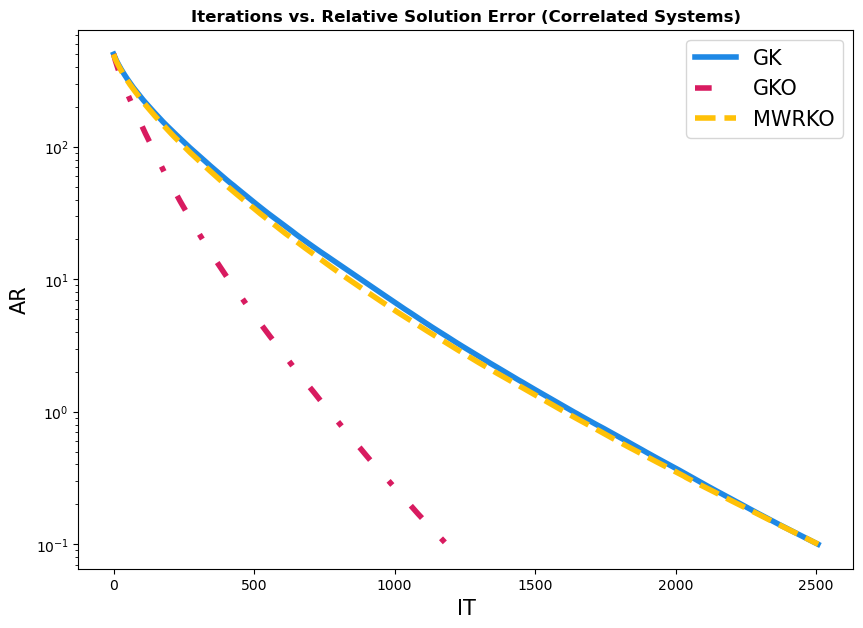

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(10,7))

plt.semilogy(np.arange(gk_corr[0]), gk_corr[1], 
             color = '#1E88E5', linewidth = 4, linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_corr[0]), gko_corr[1],
            color = '#D81B60', linewidth = 4, linestyle = (0, (3, 5, 1, 5)), label = 'GKO')
plt.semilogy(np.arange(mwrko_corr[0]), mwrko_corr[1],
            color = '#FFC107', linewidth = 4, linestyle = 'dashed', label = 'MWRKO')

plt.xlabel('IT', fontsize = 15)
plt.ylabel('AR', fontsize = 15)
plt.title('Iterations vs. Relative Solution Error (Correlated Systems)', fontweight="bold")
plt.legend(fontsize="15")
plt.show()
plt.savefig('../../outputs/synthetic-exp/5000x500/iter/5000-corr-iter.png')

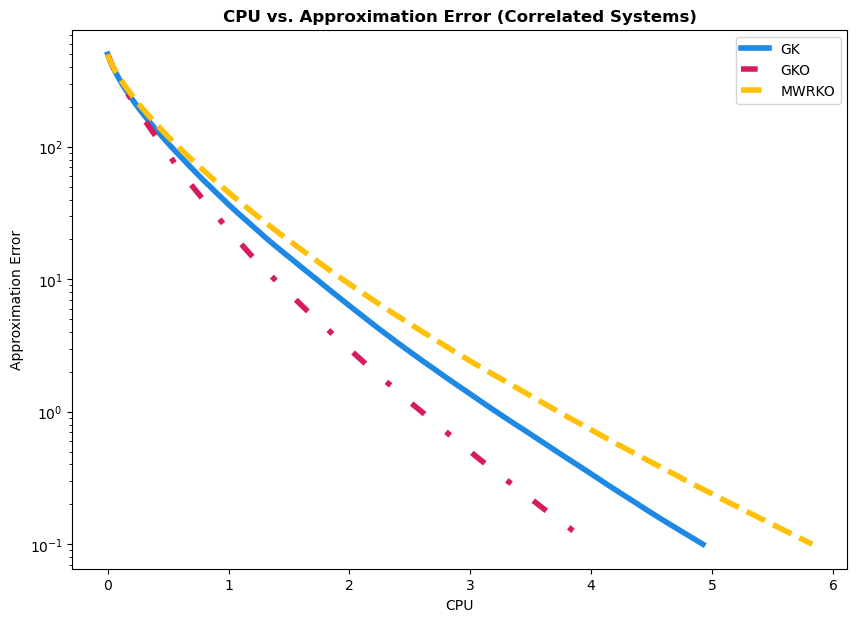

In [12]:
plt.figure(figsize=(10,7))

plt.semilogy(np.linspace(0,gk_cpu_corr,gk_corr[0]), gk_corr[1],
            color = '#1E88E5', linewidth = 4, linestyle = 'solid', label = 'GK')
plt.semilogy(np.linspace(0,gko_cpu_corr,gko_corr[0]), gko_corr[1],
            color = '#D81B60', linewidth = 4, linestyle = (0, (3, 5, 1, 5)), label = 'GKO')
plt.semilogy(np.linspace(0,mwrko_cpu_corr,mwrko_corr[0]), mwrko_corr[1],
            color = '#FFC107', linewidth = 4, linestyle = 'dashed', label = 'MWRKO')

plt.xlabel('CPU')
plt.ylabel('Approximation Error')
plt.title('CPU vs. Approximation Error (Correlated Systems)',  fontweight="bold")
plt.legend(fontsize="15")
plt.legend()
plt.savefig('../../outputs/synthetic-exp/5000x500/iter/5000-corr-cpu.png')